# Dataset import and preprocessing

**Imports**

In [1]:
import kagglehub, os, shutil, random, torch, cv2
from tqdm import tqdm
import numpy as np
import tensorflow as tf
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from PIL import Image 
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'tensorflow'

**Fixed random seed for reproducability**

In [ ]:
# fix result (adapted from Monshi et al 2021)
# https://github.com/MaramMonshi/CovidXrayNet/blob/main/DataAugmentation/1-resize.ipynb 
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    tf.random.set_seed(seed)
    
SEED = 42
seed_everything(SEED)

**Dataset import**

In [3]:
# Copy to current directory
target_dir = "chest_xray_data"

if not os.path.exists(target_dir):

    # Download the dataset
    path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

    print("Downloaded to cache:", path)

    shutil.copytree(path, target_dir)
    print(f"Dataset copied to: {target_dir}")
    
else:
    print(f"Dataset already exists at: {target_dir}")

print("\nDataset ready at:", os.path.abspath(target_dir))

Dataset already exists at: chest_xray_data

Dataset ready at: c:\Users\eirik\Desktop\FYSSTK3155_Dataprocessing_and_MachineLearning\Project3_FYSSTK3155-4155\Code\chest_xray_data


### Dataset reshuffle and train, test, val split 80/10/10

Copied from: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/discussion/485689 

In [4]:
dataset_path = 'chest_xray_data/chest_xray'
new_dataset_path = 'chest_xray_data_split'

if not os.path.exists(new_dataset_path):
    for split in ['train', 'val', 'test']:
        for cls in ['NORMAL', 'PNEUMONIA']:
            os.makedirs(f'{new_dataset_path}/{split}/{cls}', exist_ok=True)

    for cls in ['NORMAL', 'PNEUMONIA']:
        all_files = []
        for split in ['train', 'val', 'test']:
            source_folder = f'{dataset_path}/{split}/{cls}'
            files = os.listdir(source_folder)
            all_files.extend([(file, source_folder) for file in files])

        random.shuffle(all_files)

        train_files = all_files[:int(len(all_files)*0.8)]
        val_files = all_files[int(len(all_files)*0.8):int(len(all_files)*0.9)]
        test_files = all_files[int(len(all_files)*0.9):]

        for file, source_folder in train_files:
            dest = f'{new_dataset_path}/train/{cls}/{file}'
            shutil.copy(f'{source_folder}/{file}', dest)

        for file, source_folder in val_files:
            dest = f'{new_dataset_path}/val/{cls}/{file}'
            shutil.copy(f'{source_folder}/{file}', dest)

        for file, source_folder in test_files:
            dest = f'{new_dataset_path}/test/{cls}/{file}'
            shutil.copy(f'{source_folder}/{file}', dest)  

    print("\nDataset ready at:", os.path.abspath(new_dataset_path))
   
else:
    print(f"Dataset already exists at: {new_dataset_path}")

Dataset already exists at: chest_xray_data_split


**Find the smallest and largest image dimensions present in the dataset** \
Used to investigate variation in size

In [5]:
dataset_path = 'chest_xray_data_split'
sizes = []

for split in ['train', 'val', 'test']:
    for cls in ['NORMAL', 'PNEUMONIA']:
        folder = f'{dataset_path}/{split}/{cls}'
        for filename in os.listdir(folder):
            img = Image.open(os.path.join(folder, filename))
            width, height = img.size
            sizes.append((width * height, width, height, filename))

sizes.sort()  # Sort from smallest to largest

print("Top 5 smallest images:")
for i in range(5):
    pixels, w, h, name = sizes[i]
    print(f"{name}: {w} x {h} ({pixels:,} pixels)")


sizes.sort(reverse=True)  # Sort from largest to smallest

print("\nTop 5 largest images:")
for i in range(5):
    pixels, w, h, name = sizes[i]
    print(f"{name}: {w} x {h} ({pixels:,} pixels)")

Top 5 smallest images:
person407_virus_811.jpeg: 384 x 127 (48,768 pixels)
person325_virus_660.jpeg: 400 x 138 (55,200 pixels)
person325_virus_661.jpeg: 446 x 132 (58,872 pixels)
person325_virus_659.jpeg: 445 x 140 (62,300 pixels)
person1689_bacteria_4474.jpeg: 437 x 144 (62,928 pixels)

Top 5 largest images:
NORMAL2-IM-1257-0001.jpeg: 2916 x 2583 (7,532,028 pixels)
IM-0521-0001.jpeg: 2890 x 2534 (7,323,260 pixels)
NORMAL2-IM-1018-0001.jpeg: 2694 x 2625 (7,071,750 pixels)
NORMAL2-IM-0602-0001.jpeg: 2619 x 2628 (6,882,732 pixels)
NORMAL2-IM-0030-0001.jpeg: 2517 x 2713 (6,828,621 pixels)


**Data preprocessing**

In [ ]:
# Define the transforms to do for training data
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((480, 480)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Define the transforms to do for validation and testing data
val_test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((480, 480)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load datasets with progress bar
def load_data(path, train_aug=True):
    transform = train_transform if train_aug else val_test_transform
    dataset = datasets.ImageFolder(path, transform=transform)
    
    images = []
    labels = []
    for i in tqdm(range(len(dataset)), desc=f"Loading {path.split('/')[-1]}"):
        img, label = dataset[i]
        images.append(img.numpy().squeeze())
        labels.append(label)
    
    return np.array(images), np.array(labels)

X_train, y_train = load_data('chest_xray_data_split/train', train_aug=True)
X_val, y_val = load_data('chest_xray_data_split/val', train_aug=False)
X_test, y_test = load_data('chest_xray_data_split/test', train_aug=False)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Loading test: 100%|██████████| 587/587 [00:03<00:00, 157.46it/s]

Train: (4684, 480, 480), Val: (585, 480, 480), Test: (587, 480, 480)


**Visualization of data**

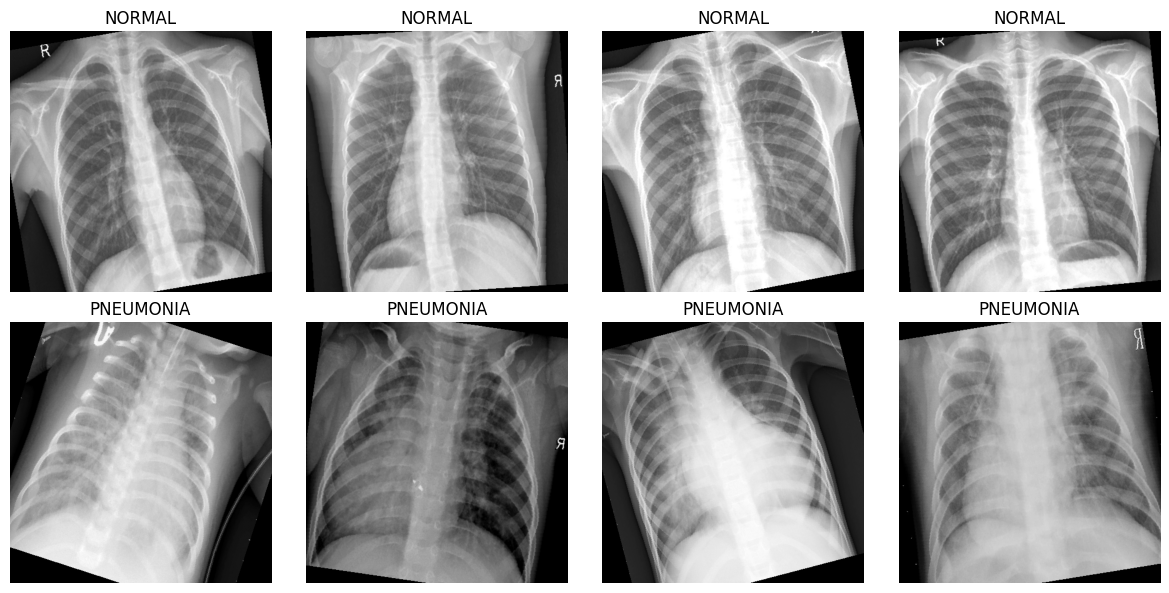

In [19]:
def denormalize(img):
    return np.clip(img * 0.5 + 0.5, 0, 1)

# Get 4 samples from each class
normal_indices = np.where(y_train == 0)[0][:4]
pneumonia_indices = np.where(y_train == 1)[0][:4]
indices = np.concatenate([normal_indices, pneumonia_indices])

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i in range(8):
    row, col = i // 4, i % 4
    idx = indices[i]
    img = denormalize(X_train[idx])
    axes[row, col].imshow(img, cmap='gray')
    axes[row, col].set_title(['NORMAL', 'PNEUMONIA'][y_train[idx]])
    axes[row, col].axis('off')
plt.tight_layout()
plt.show()

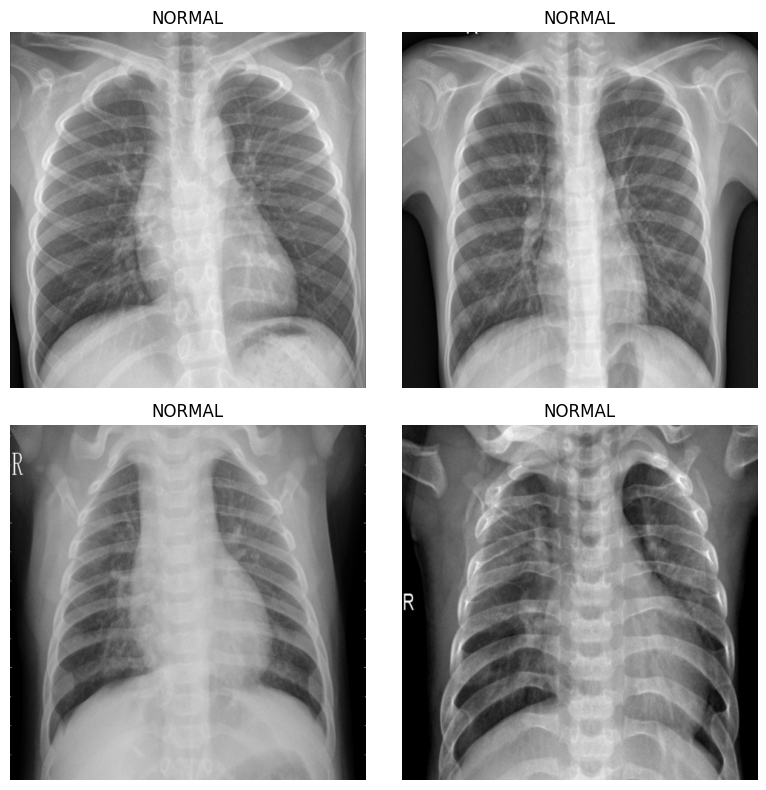

In [26]:
def denormalize(img):
    return np.clip(img * 0.5 + 0.5, 0, 1)

# Get 2 samples from each class
normal_indices = np.where(y_val == 0)[0][:2]
pneumonia_indices = np.where(y_val == 1)[0][:2]
indices = np.concatenate([normal_indices, pneumonia_indices])

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
for i in range(4):
    row, col = i // 2, i % 2
    idx = indices[i]
    img = denormalize(X_val[idx])
    axes[row, col].imshow(img, cmap='gray')
    axes[row, col].set_title(['NORMAL', 'PNEUMONIA'][y_train[idx]])
    axes[row, col].axis('off')
plt.tight_layout()
plt.show()